In [594]:
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

In [595]:
sns.set(font_scale=1.5)

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = None

In [596]:
df = pd.read_excel('Data/Real_Estate Data.xlsx')

### Preliminary exploration

In [597]:
display(df.head(), df.shape)

,Sr. No.,Location,Sub-Area,Propert Type,Property Area in Sq. Ft.,Price in lakhs,Price in Millions,Company Name,TownShip Name/ Society Name,Total TownShip Area in Acres,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
0,1,"Pune, Maharashtra, India",Bavdhan,1 BHK,492,39,3.9,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1,2,"Pune, Maharashtra, India",Bavdhan,2 BHK,774,65,6.5,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2,3,"Pune, Maharashtra, India",Bavdhan,3 BHK,889,74,7.4,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3,4,"Pune, Maharashtra, India",Bavdhan,3 BHK Grand,1018,89,8.9,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
4,5,"Pune, Maharashtra, India",Mahalunge,2BHK,743,74,7.4,Godrej Properties,Godrej Hills retreat,100.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes


(200, 17)

In [598]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Sr. No.                           200 non-null    int64  
 1   Location                          200 non-null    object 
 2   Sub-Area                          200 non-null    object 
 3   Propert Type                      200 non-null    object 
 4   Property Area in Sq. Ft.          200 non-null    object 
 5   Price in lakhs                    200 non-null    object 
 6   Price in Millions                 199 non-null    float64
 7   Company Name                      200 non-null    object 
 8   TownShip Name/ Society Name       200 non-null    object 
 9   Total TownShip Area in Acres      51 non-null     float64
 10  ClubHouse                         200 non-null    object 
 11  School / University in Township   200 non-null    object 
 12  Hospital

In [599]:
df.rename(columns={'Propert Type': 'Property Type'}, inplace=True)

In [600]:
df['Property Type'].unique()

array(['1 BHK', '2 BHK', '3 BHK', '3 BHK Grand', '2BHK', '3BHK', '4BHK',
       '5BHK', '6BHK', '1BHK', 'shop', '2 bhk', '2bhk ', '3  bhk ',
       '3 bhk', '2bhk', '2.5 BHK', '3 BHK ', '4 bhk', '1 bhk', '2.5 bhk',
       '1bhk', '3bhk', '3.5bhk', '3.5 bhk', '3bhk ', '2+2 bhk', '3+2bhk ',
       '2 bhk ', '5 bhk', '1bhk ', '4.5bhk', '4bhk'], dtype=object)

In [601]:
df = df[df['Property Type'] != 'shop']
df.shape

(199, 17)

#### property type needs cleaning

In [602]:
df['Property Area in Sq. Ft.'].unique()

array([492, 774, 889, 1018, 743, 975, '877 to 912', '1077 to 1272', 905,
       1125, 1644, 2220, '662 to 845', '890 to 1212', 423, 665,
       '792 to 965', 462, 666, 750, 1030, 446, 796, 842, 865, 902, 1154,
       872, 934, 1088, 1109, 1163, 1419, 1485, 684, 990, 882, 1103, 543,
       '801 to 1125', '1272 to 2138', 320, 473, 581, 790, 820, 989, 1003,
       1182, 1579, 491, 659, 732, 809, 460, 734, 753, 675, 917, 670, 740,
       847, 936, 1032, 1698, 2267, 725, 731, 744, 923, 930, 792, 1180,
       860, 988, 1093, 456, 644, 785, 1060, 113, 664, 673, 682, 698, 1239,
       1315, 1388, 1463, 1671, 1687, 575, 751, 761, 871, 1166, 1206, 1272,
       1279, 646, 717, 436, 637, 642, 655, 668, 810, 735, 783, 805, 1074,
       1111, 535, 947, 697, 711, 980, 1400, 1772, 1662, 705, 726, 793,
       904, 1168, 1189, 479, 693, 808, 1086, 844, 873, 606, 611, 626, 691,
       835, 854, 715, '624 to 761', 968, 996, 1038, 489, 598, 616, 692,
       867, 908, 1624, 2043, 727, '561 to 902', '1056 to

#### In property Area column there is a mix of integers and strings the string are written like this<br> 500 to 600 for this we will compute the mean value and convert all of the data to floats.

In [603]:
def split_sum(e, flag=True):
    try:
        e = str(e).lower()
        e = re.sub(r'[,.;@#?!&$+]+\ *', ' ', e)
        e = re.sub(r'[a-z]+', ' ', e)
        e = re.sub(r'\s\s', '', e)

        s2list = e.strip().split()
        sumList = sum(float(e) for e in s2list)

        e_norm = sumList if flag else sumList / len(s2list)
        return e_norm    
    
    except:
        return np.nan
    
def normalize_props(df):
    data = df.copy()
    data['Property Type'] = data['Property Type'].apply(split_sum)
    data['Property Area in Sq. Ft.'] = data['Property Area in Sq. Ft.'].apply(lambda x: split_sum(x, False))

    return data

In [604]:
df_norm = normalize_props(df)

In [605]:
df_norm['Property Type'].unique()

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [606]:
df_norm['Property Area in Sq. Ft.'].unique()

array([ 492. ,  774. ,  889. , 1018. ,  743. ,  975. ,  894.5, 1174.5,
        905. , 1125. , 1644. , 2220. ,  753.5, 1051. ,  423. ,  665. ,
        878.5,  462. ,  666. ,  750. , 1030. ,  446. ,  796. ,  842. ,
        865. ,  902. , 1154. ,  872. ,  934. , 1088. , 1109. , 1163. ,
       1419. , 1485. ,  684. ,  990. ,  882. , 1103. ,  543. ,  963. ,
       1705. ,  320. ,  473. ,  581. ,  790. ,  820. ,  989. , 1003. ,
       1182. , 1579. ,  491. ,  659. ,  732. ,  809. ,  460. ,  734. ,
        753. ,  675. ,  917. ,  670. ,  740. ,  847. ,  936. , 1032. ,
       1698. , 2267. ,  725. ,  731. ,  744. ,  923. ,  930. ,  792. ,
       1180. ,  860. ,  988. , 1093. ,  456. ,  644. ,  785. , 1060. ,
        113. ,  664. ,  673. ,  682. ,  698. , 1239. , 1315. , 1388. ,
       1463. , 1671. , 1687. ,  575. ,  751. ,  761. ,  871. , 1166. ,
       1206. , 1272. , 1279. ,  646. ,  717. ,  436. ,  637. ,  642. ,
        655. ,  668. ,  810. ,  735. ,  783. ,  805. , 1074. , 1111. ,
      

In [607]:
df_norm.dtypes

Sr. No.                               int64
Location                             object
Sub-Area                             object
Property Type                       float64
Property Area in Sq. Ft.            float64
Price in lakhs                       object
Price in Millions                   float64
Company Name                         object
TownShip Name/ Society Name          object
Total TownShip Area in Acres        float64
ClubHouse                            object
School / University in Township      object
Hospital in TownShip                 object
Mall in TownShip                     object
Park / Jogging track                 object
Swimming Pool                        object
Gym                                  object
dtype: object

### Cleaning the outliers

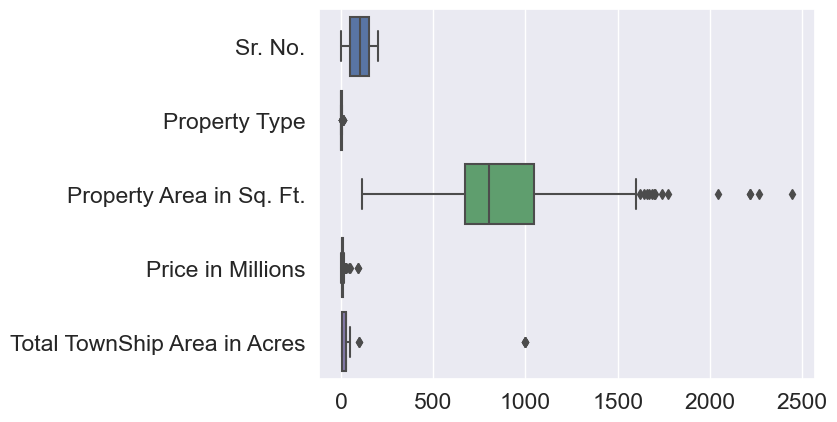

In [608]:
sns.boxplot(data=df_norm, orient='h')
plt.show()

In [609]:
def compute_upper(df_col, up=True):
    iqr = df_col.quantile(.75) - df_col.quantile(.25)

    if up:
        return df_col.quantile(.75) + 1.5 * iqr
    return df_col.quantile(.25) - 1.5 * iqr

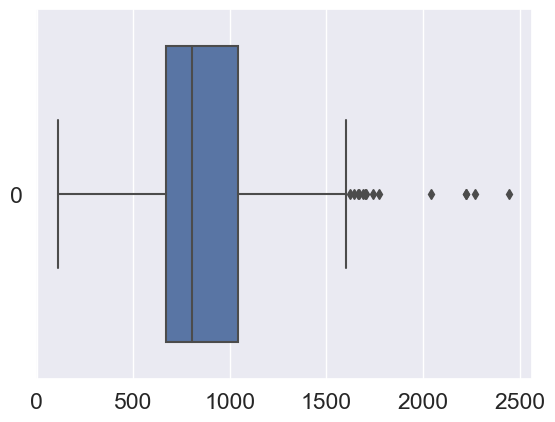

In [610]:
sns.boxplot(data=df_norm['Property Area in Sq. Ft.'], orient='h')
plt.show()

In [611]:
x_pa = df_norm['Property Area in Sq. Ft.']
pa_up_lim = compute_upper(x_pa)
df_norm[x_pa > pa_up_lim]

,Sr. No.,Location,Sub-Area,Property Type,Property Area in Sq. Ft.,Price in lakhs,Price in Millions,Company Name,TownShip Name/ Society Name,Total TownShip Area in Acres,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
10,11,"Pune, Maharashtra, India",Ravet,4.0,1644.0,135,13.5,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
11,12,"Pune, Maharashtra, India",Ravet,5.0,2220.0,188,18.8,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
12,13,"Pune, Maharashtra, India",Ravet,6.0,2220.0,188,18.8,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
41,42,"Pune, Maharashtra, India",Keshav Nagar,3.0,1705.0,Null,NaN,Mantra Properties,Mantra Insignia,NaN,Yes,No,No,No,Yes,Yes,Yes
67,68,"Pune, Maharashtra, India",kayani nagar,3.0,1698.0,249,24.9,sagitarius ecospaces llp,bluegrass residences,NaN,yes,no,no,no,yes,yes,yes
68,69,"Pune, Maharashtra, India",kayani nagar,4.0,2267.0,460,46.0,sagitarius ecospaces llp,bluegrass residences,NaN,yes,no,no,no,yes,yes,yes
96,97,"Pune, Maharashtra, India",NIBM,8.0,1671.0,211,21.1,kundan Spaces,Presidia,NaN,yes,no,no,no,yes,Yes,yes
97,98,"Pune, Maharashtra, India",NIBM,8.0,1687.0,213,21.3,kundan Spaces,Presidia,NaN,yes,no,no,no,yes,Yes,yes
128,129,"Pune, Maharashtra, India",Hinjewadi,5.0,1772.0,177,17.7,Shapoorji Paloonji,Sensorium,NaN,yes,no,no,no,yes,yes,yes
131,132,"Pune, Maharashtra, India",hadapsar,5.0,1662.0,130,13.0,Wellwisher Apartments,kiarah terrazo,NaN,no,no,no,no,yes,no,no


#### we won't consider these as outliers seeing that the larger the property area the more bedrooms they have

<Axes: >

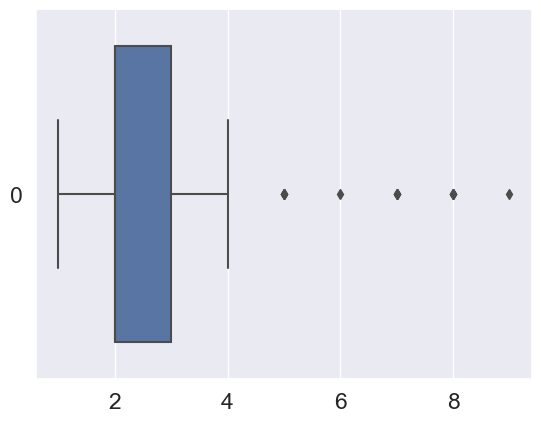

In [612]:
sns.boxplot(data=df_norm['Property Type'], orient='h')

In [613]:
x_prt = df_norm['Property Type']
prt_up_lim = compute_upper(x_prt)
df_norm[x_prt > prt_up_lim]

,Sr. No.,Location,Sub-Area,Property Type,Property Area in Sq. Ft.,Price in lakhs,Price in Millions,Company Name,TownShip Name/ Society Name,Total TownShip Area in Acres,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
11,12,"Pune, Maharashtra, India",Ravet,5.0,2220.0,188,18.800,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
12,13,"Pune, Maharashtra, India",Ravet,6.0,2220.0,188,18.800,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
50,51,"Pune, Maharashtra, India",Akurdi,5.0,1579.0,163,16.300,Mantra Properties,Mantra Sky Tower,3.5,Yes,No,No,No,Yes,Yes,Yes
63,64,"Pune, Maharashtra, India",kiwale,7.0,847.0,69.38,6.938,unique properties,k ville,NaN,yes,no,No,No,yes,yes,no
64,65,"Pune, Maharashtra, India",kiwale,7.0,936.0,75.03,7.503,unique properties,k ville,NaN,yes,no,No,No,yes,yes,no
77,78,"Pune, Maharashtra, India",manjri,7.0,792.0,65.5,6.550,jhala group,tranquility annexe,NaN,yes,no,no,no,yes,yes,yes
84,85,"Pune, Maharashtra, India",handewadi,7.0,785.0,55.22,5.522,jhala group,simplicity,NaN,yes,no,no,no,yes,no,yes
86,87,"Pune, Maharashtra, India",koregoan,8.0,113.0,143,14.300,shroff developers,aureta,NaN,no,no,no,no,yes,yes,yes
96,97,"Pune, Maharashtra, India",NIBM,8.0,1671.0,211,21.100,kundan Spaces,Presidia,NaN,yes,no,no,no,yes,Yes,yes
97,98,"Pune, Maharashtra, India",NIBM,8.0,1687.0,213,21.300,kundan Spaces,Presidia,NaN,yes,no,no,no,yes,Yes,yes


In [614]:
df_norm.drop(index=86, inplace=True)

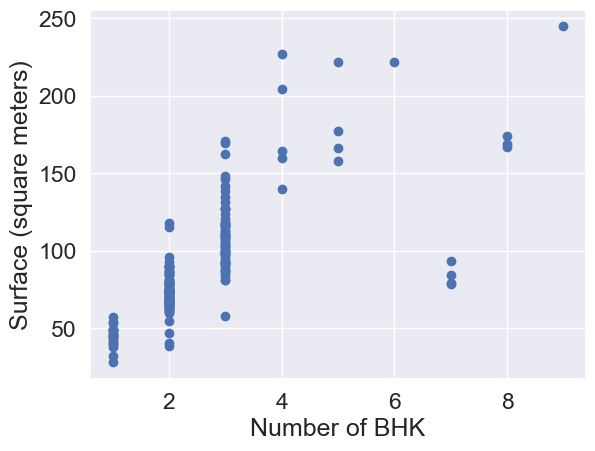

In [615]:
plt.scatter(df_norm['Property Type'], df_norm['Property Area in Sq. Ft.']*.1 )
plt.xlabel('Number of BHK')
plt.ylabel('Surface (square meters)')
plt.show()

In [616]:
df_norm.drop(index=df_norm[df_norm['Property Type'] == 7].index, inplace=True)
df_norm.shape


(194, 17)

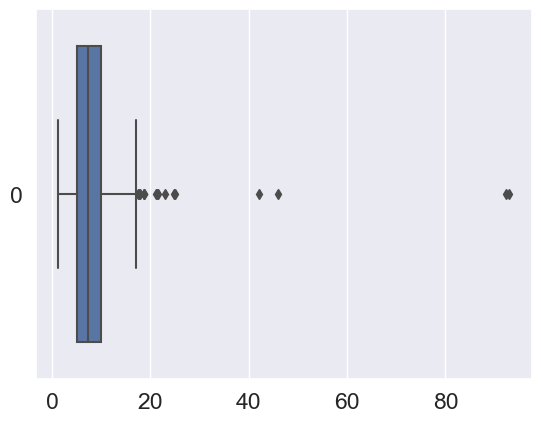

In [617]:
sns.boxplot(data=df_norm['Price in Millions'], orient='h')
plt.show()

In [618]:
x_pim = df_norm['Price in Millions']
pim_up_lim = compute_upper(x_pim)
df_norm[ x_pim > pim_up_lim ]

,Sr. No.,Location,Sub-Area,Property Type,Property Area in Sq. Ft.,Price in lakhs,Price in Millions,Company Name,TownShip Name/ Society Name,Total TownShip Area in Acres,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
11,12,"Pune, Maharashtra, India",Ravet,5.0,2220.0,188,18.8,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
12,13,"Pune, Maharashtra, India",Ravet,6.0,2220.0,188,18.8,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
67,68,"Pune, Maharashtra, India",kayani nagar,3.0,1698.0,249,24.9,sagitarius ecospaces llp,bluegrass residences,NaN,yes,no,no,no,yes,yes,yes
68,69,"Pune, Maharashtra, India",kayani nagar,4.0,2267.0,460,46.0,sagitarius ecospaces llp,bluegrass residences,NaN,yes,no,no,no,yes,yes,yes
73,74,"Pune, Maharashtra, India",pisoli,3.0,923.0,923,92.3,nirman developers,brookefield willows,NaN,yes,no,no,no,yes,yes,yes
74,75,"Pune, Maharashtra, India",pisoli,3.0,930.0,930,93.0,nirman developers,brookefield willows,NaN,yes,no,no,no,yes,yes,yes
94,95,"Pune, Maharashtra, India",NIBM,3.0,1388.0,178,17.8,kundan Spaces,Presidia,NaN,yes,no,no,no,yes,Yes,yes
95,96,"Pune, Maharashtra, India",NIBM,3.0,1463.0,187,18.7,kundan Spaces,Presidia,NaN,yes,no,no,no,yes,Yes,yes
96,97,"Pune, Maharashtra, India",NIBM,8.0,1671.0,211,21.1,kundan Spaces,Presidia,NaN,yes,no,no,no,yes,Yes,yes
97,98,"Pune, Maharashtra, India",NIBM,8.0,1687.0,213,21.3,kundan Spaces,Presidia,NaN,yes,no,no,no,yes,Yes,yes


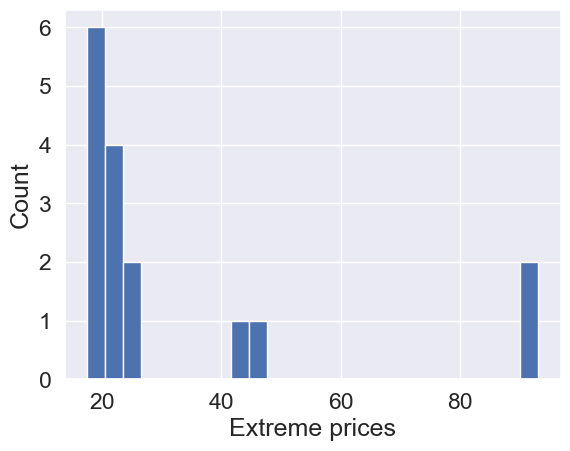

In [619]:
df_norm[x_pim > pim_up_lim]['Price in Millions'].hist(bins=25)
plt.xlabel('Extreme prices')
plt.ylabel('Count')
plt.show()

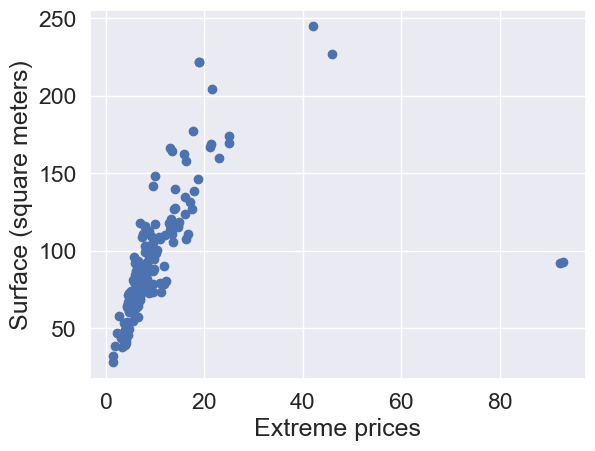

In [620]:
plt.scatter(x=df_norm['Price in Millions'],
            y=df_norm['Property Area in Sq. Ft.']*.1 )
plt.xlabel('Extreme prices')
plt.ylabel('Surface (square meters)')
plt.show()

#### From the histogram and scatter plot we can see that index 73 and 74 are definitely outliers

In [621]:
df_norm = df_norm[df_norm['Price in Millions'] < 80]

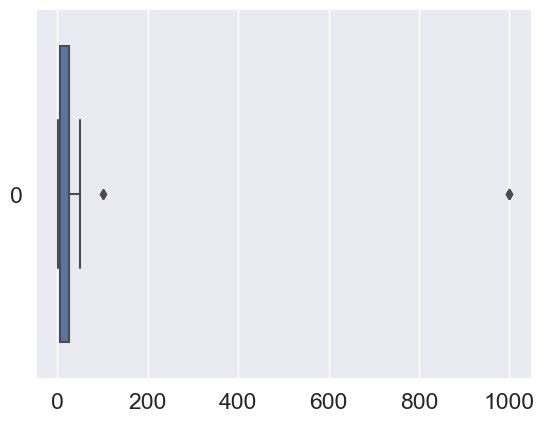

In [622]:
sns.boxplot(data=df_norm['Total TownShip Area in Acres'], orient='h')
plt.show()

In [623]:
x_tta = df_norm['Total TownShip Area in Acres']
tta_up_lim = compute_upper(x_tta)
df_norm[ x_tta > tta_up_lim ]


,Sr. No.,Location,Sub-Area,Property Type,Property Area in Sq. Ft.,Price in lakhs,Price in Millions,Company Name,TownShip Name/ Society Name,Total TownShip Area in Acres,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
0,1,"Pune, Maharashtra, India",Bavdhan,1.0,492.0,39,3.9,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1,2,"Pune, Maharashtra, India",Bavdhan,2.0,774.0,65,6.5,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2,3,"Pune, Maharashtra, India",Bavdhan,3.0,889.0,74,7.4,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3,4,"Pune, Maharashtra, India",Bavdhan,3.0,1018.0,89,8.9,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
4,5,"Pune, Maharashtra, India",Mahalunge,2.0,743.0,74,7.4,Godrej Properties,Godrej Hills retreat,100.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
5,6,"Pune, Maharashtra, India",Mahalunge,3.0,975.0,95,9.5,Godrej Properties,Godrej Hills retreat,100.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes


In [624]:
tta_low_lim = compute_upper(x_tta)
df_norm[ x_tta < tta_low_lim ]

,Sr. No.,Location,Sub-Area,Property Type,Property Area in Sq. Ft.,Price in lakhs,Price in Millions,Company Name,TownShip Name/ Society Name,Total TownShip Area in Acres,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
6,7,"Pune, Maharashtra, India",Balewadi,2.0,894.5,75,7.5,ANP CORP,ANP Universe,25.0,Yes,No,No,No,Yes,Yes,Yes
7,8,"Pune, Maharashtra, India",Balewadi,3.0,1174.5,100,10.0,ANP CORP,ANP Universe,25.0,Yes,No,No,No,Yes,Yes,Yes
8,9,"Pune, Maharashtra, India",Ravet,2.0,905.0,65,6.5,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
9,10,"Pune, Maharashtra, India",Ravet,3.0,1125.0,88,8.8,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
10,11,"Pune, Maharashtra, India",Ravet,4.0,1644.0,135,13.5,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
11,12,"Pune, Maharashtra, India",Ravet,5.0,2220.0,188,18.8,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
12,13,"Pune, Maharashtra, India",Ravet,6.0,2220.0,188,18.8,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
13,14,"Pune, Maharashtra, India",Baner,2.0,753.5,58,5.8,VTP Reality,VTP Cierra,10.0,Yes,No,No,No,Yes,Yes,Yes
14,15,"Pune, Maharashtra, India",Baner,3.0,1051.0,95,9.5,VTP Reality,VTP Cierra,10.0,Yes,No,No,No,Yes,Yes,Yes
15,16,"Pune, Maharashtra, India",Mahalunge,1.0,423.0,40,4.0,VTP Reality,VTP Blue Water,50.0,Yes,No,No,No,Yes,Yes,Yes


### Price Selection

In [625]:
df_norm['Price in lakhs'] = df_norm['Price in lakhs'].apply(lambda x: pd.to_numeric(x, errors='coerce'))

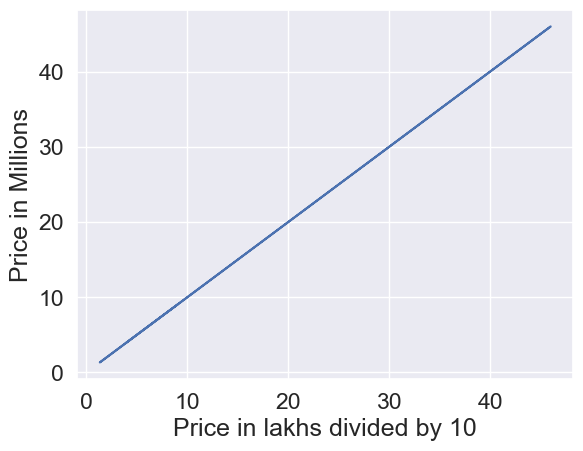

In [626]:
plt.plot(df_norm['Price in lakhs'] / 10., df_norm['Price in Millions'])
plt.xlabel('Price in lakhs divided by 10')
plt.ylabel('Price in Millions')
plt.show()

#### from this plot we conclude that price in lakhs is the same as price in millions<br>we will drop price in lakhs

In [627]:
df_norm = df_norm.drop(columns=['Price in lakhs'])

In [628]:
df_norm.head()

,Sr. No.,Location,Sub-Area,Property Type,Property Area in Sq. Ft.,Price in Millions,Company Name,TownShip Name/ Society Name,Total TownShip Area in Acres,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
0,1,"Pune, Maharashtra, India",Bavdhan,1.0,492.0,3.9,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1,2,"Pune, Maharashtra, India",Bavdhan,2.0,774.0,6.5,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2,3,"Pune, Maharashtra, India",Bavdhan,3.0,889.0,7.4,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3,4,"Pune, Maharashtra, India",Bavdhan,3.0,1018.0,8.9,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
4,5,"Pune, Maharashtra, India",Mahalunge,2.0,743.0,7.4,Godrej Properties,Godrej Hills retreat,100.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes


### Handling missing values

In [629]:
df_norm.isna().sum()

Sr. No.                               0
Location                              0
Sub-Area                              0
Property Type                         0
Property Area in Sq. Ft.              0
Price in Millions                     0
Company Name                          0
TownShip Name/ Society Name           0
Total TownShip Area in Acres        140
ClubHouse                             0
School / University in Township       0
Hospital in TownShip                  0
Mall in TownShip                      0
Park / Jogging track                  0
Swimming Pool                         0
Gym                                   0
dtype: int64

In [630]:
def compute_fill_rate(df):
    fr = pd.DataFrame(1-df.isnull().sum().values.reshape(1,-1)/df.shape[0], columns=df.columns)
    return fr


def plot_fill_rate(df):
    fill_rate = compute_fill_rate(df)
    fig, ax = plt.subplots(figsize=(18, 18))
    sns.barplot(data=fill_rate, orient='h')
    ax.set_title('Fill rate for columns', fontsize=28)
    ax.set(xlim=(0, 1.))

def drop_empty_axis(df, minFillRate, axis=1):
    i = 0 if axis == 1 else 1
    return df.dropna(axis=axis, thresh=int(df.shape[i] * minFillRate))


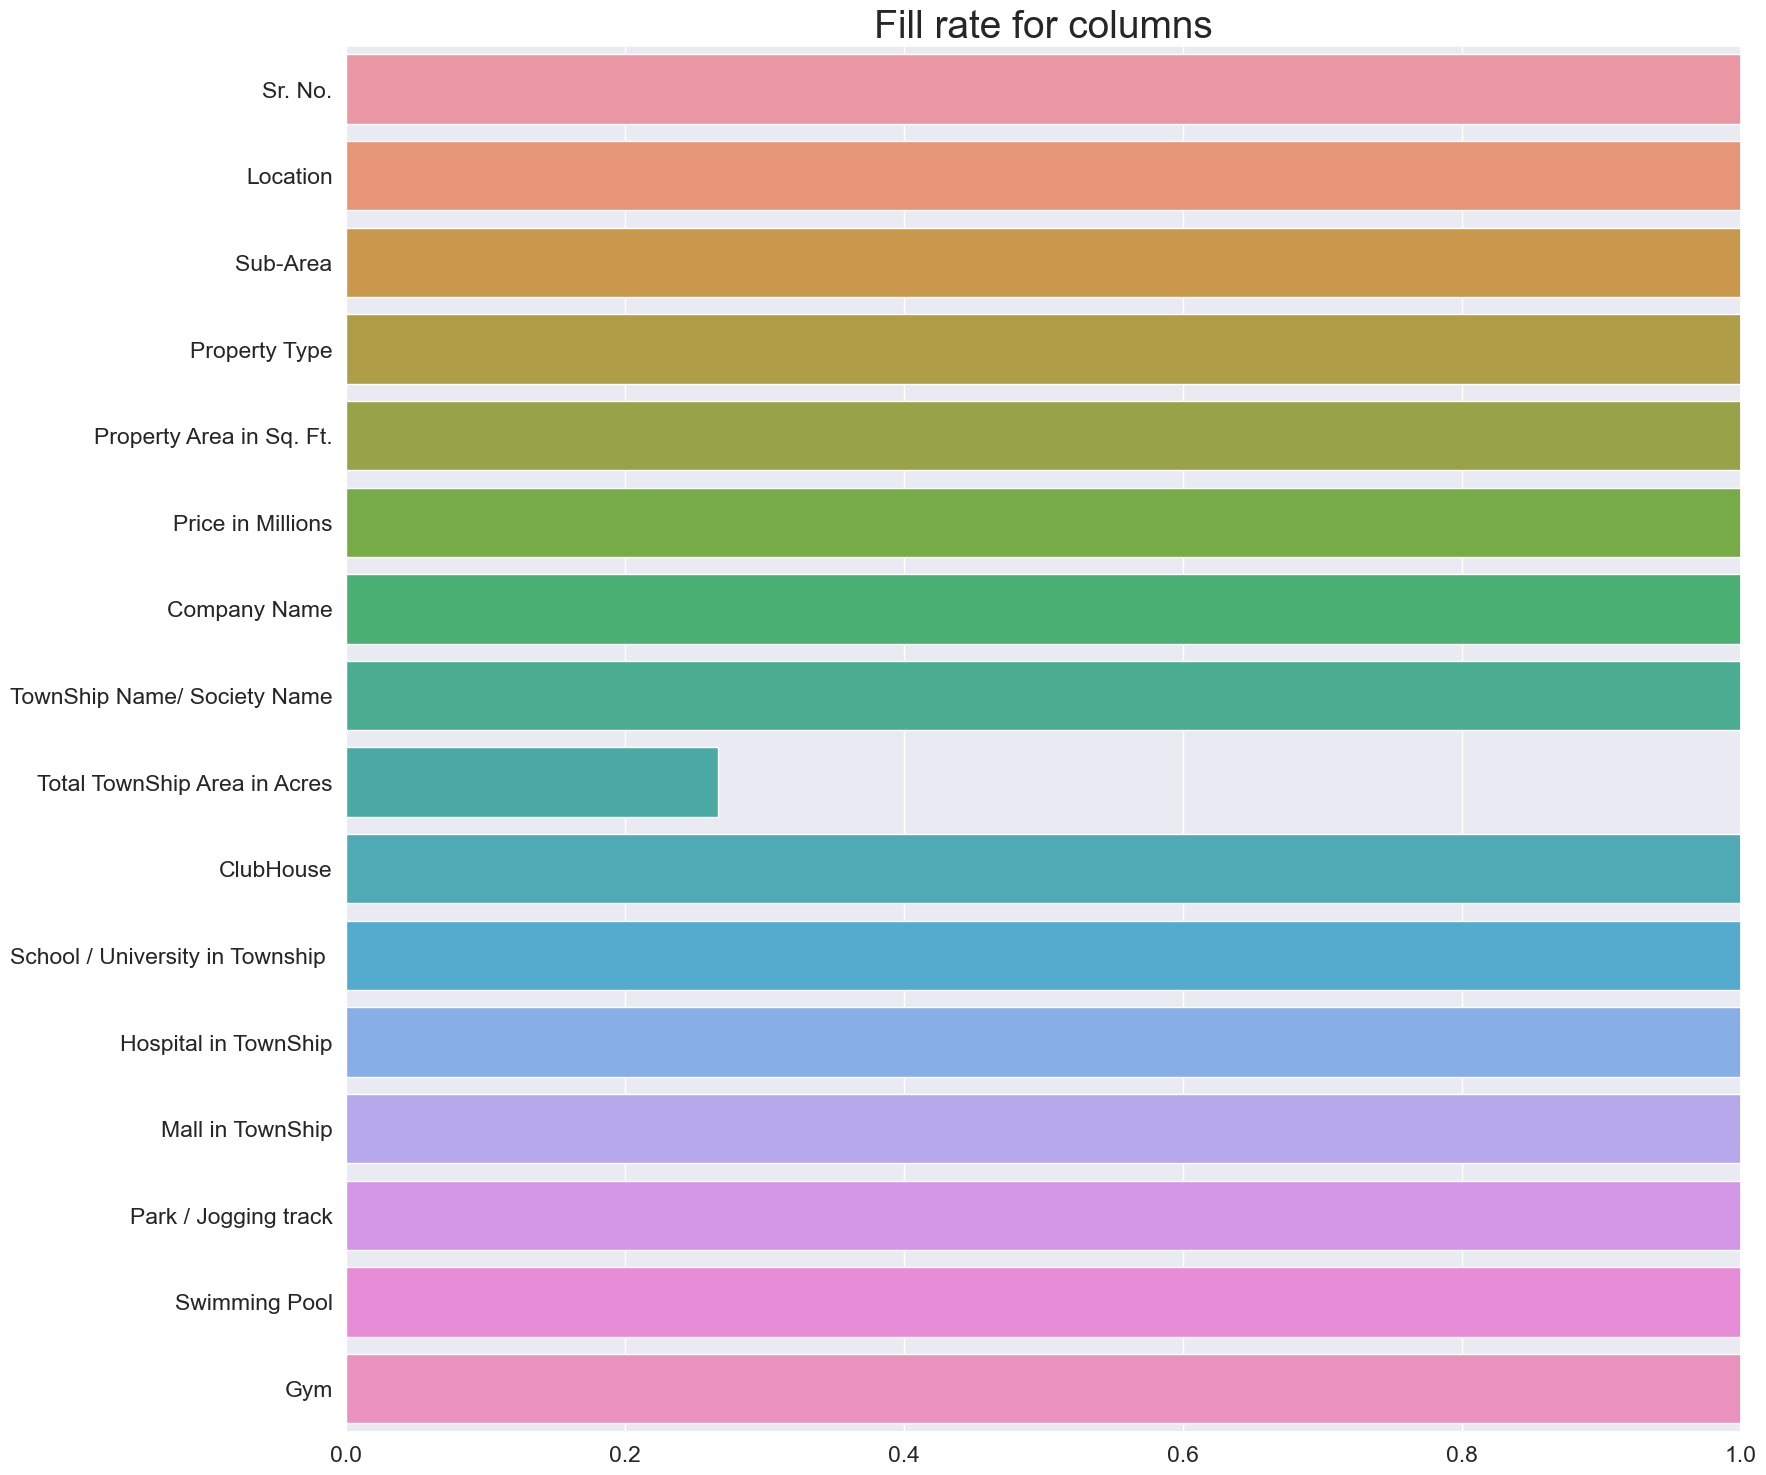

In [631]:
plot_fill_rate(df_norm)

In [632]:
compute_fill_rate(df_norm)

,Sr. No.,Location,Sub-Area,Property Type,Property Area in Sq. Ft.,Price in Millions,Company Name,TownShip Name/ Society Name,Total TownShip Area in Acres,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.267016,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [633]:
df_norm[['Sub-Area', 'TownShip Name/ Society Name', 'Total TownShip Area in Acres' ]].sort_values('Sub-Area').reset_index(drop=True)

,Sub-Area,TownShip Name/ Society Name,Total TownShip Area in Acres
0,Akurdi,Mantra Sky Tower,3.5
1,Akurdi,Mantra Sky Tower,3.5
2,Akurdi,Mantra Sky Tower,3.5
3,Akurdi,Mantra Sky Tower,3.5
4,Akurdi,Mantra Sky Tower,3.5
5,Akurdi,Mantra Sky Tower,3.5
6,BANER,TEJ ELEVIA,2.5
7,BANER,vtp solitaire,NaN
8,BANER,SUPREME ESTIA,5.0
9,BANER,SUPREME ESTIA,5.0


In [634]:
df_norm = drop_empty_axis(df_norm, minFillRate=.5)

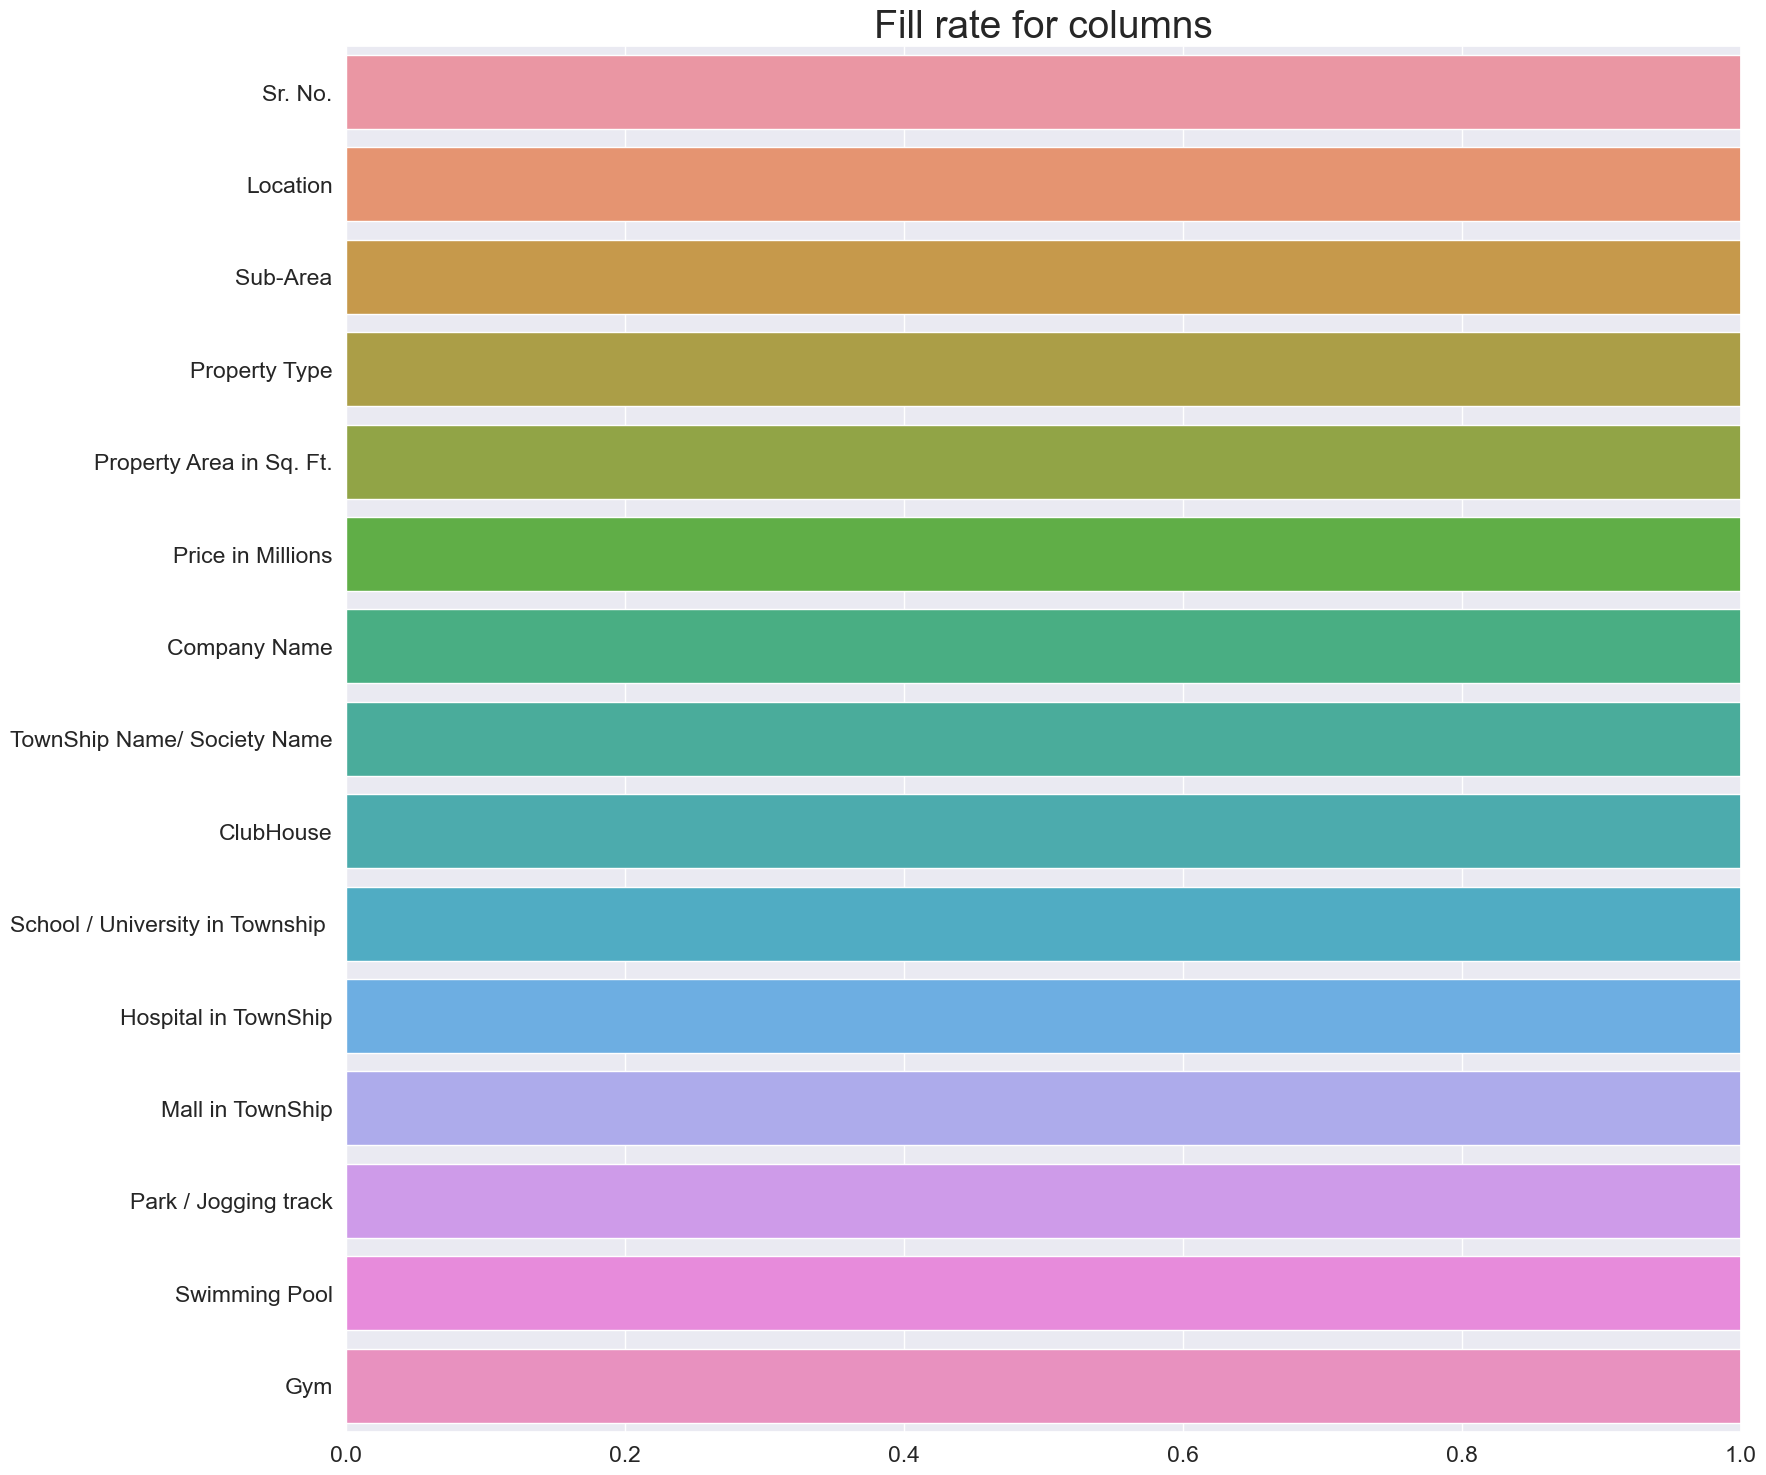

In [635]:
plot_fill_rate(df_norm)

#### Regularize the categorical columns

In [636]:
df_norm.select_dtypes(include='object').head(3)

,Location,Sub-Area,Company Name,TownShip Name/ Society Name,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
0,"Pune, Maharashtra, India",Bavdhan,Shapoorji Paloonji,Vanaha,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1,"Pune, Maharashtra, India",Bavdhan,Shapoorji Paloonji,Vanaha,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2,"Pune, Maharashtra, India",Bavdhan,Shapoorji Paloonji,Vanaha,Yes,Yes,Yes,Yes,Yes,Yes,Yes


### Binary categorical columns

In [637]:
binary_cols = df_norm.iloc[:,-7:].columns.to_list()
binary_cols

['ClubHouse',
 'School / University in Township ',
 'Hospital in TownShip',
 'Mall in TownShip',
 'Park / Jogging track',
 'Swimming Pool',
 'Gym']

In [638]:
def print_uniques(cols, df=df_norm):
    for col in cols:
        list_unique = df[col].unique()
        list_unique.sort()
        print(col, ":\n", list_unique)
        print('Number of unique categories:', len(list_unique))
        print('------------------')

In [639]:
print_uniques(binary_cols)

ClubHouse :
 ['Yes' 'no' 'no ' 'yes']
Number of unique categories: 4
------------------
School / University in Township  :
 ['No' 'Yes' 'no']
Number of unique categories: 3
------------------
Hospital in TownShip :
 ['No' 'Yes' 'no']
Number of unique categories: 3
------------------
Mall in TownShip :
 ['No' 'Yes' 'no' 'no ']
Number of unique categories: 4
------------------
Park / Jogging track :
 ['No' 'Yes' 'no' 'yes']
Number of unique categories: 4
------------------
Swimming Pool :
 ['No' 'Yes' 'no' 'no ' 'yes']
Number of unique categories: 5
------------------
Gym :
 ['Yes' 'no' 'no ' 'yes']
Number of unique categories: 4
------------------


In [640]:
for col in binary_cols:
    df_norm[col] = df_norm[col].apply(lambda x: x.strip().lower())

print_uniques(binary_cols)

ClubHouse :
 ['no' 'yes']
Number of unique categories: 2
------------------
School / University in Township  :
 ['no' 'yes']
Number of unique categories: 2
------------------
Hospital in TownShip :
 ['no' 'yes']
Number of unique categories: 2
------------------
Mall in TownShip :
 ['no' 'yes']
Number of unique categories: 2
------------------
Park / Jogging track :
 ['no' 'yes']
Number of unique categories: 2
------------------
Swimming Pool :
 ['no' 'yes']
Number of unique categories: 2
------------------
Gym :
 ['no' 'yes']
Number of unique categories: 2
------------------


#### Multi-categorical columns

In [641]:
obj_cols = df_norm.select_dtypes(include='object').columns.to_list()
multiCat_cols = list(set(obj_cols)^set(binary_cols))
multiCat_cols

['TownShip Name/ Society Name', 'Company Name', 'Location', 'Sub-Area']

In [642]:
for col in multiCat_cols:
    df_norm[col] = df_norm[col].apply(lambda x: x.strip().lower())

In [643]:
print_uniques(multiCat_cols)

TownShip Name/ Society Name :
 ['7hills' 'abitante fiore' 'anp universe' 'anutham' 'atulya kanhe'
 'aureta' 'bhaktamar residency' 'bliss solitaire' 'bluegrass residences'
 'brookefield willows' 'dolphin garima' 'eternia 2.0'
 'godrej hills retreat' 'impero' 'infinity' 'jade residences' 'k ville'
 'kalpataru serenity' 'khush vista' 'kiarah terrazo' 'lesiure town'
 'mahalunge riviera' 'mantra 29 gold' 'mantra insignia' 'mantra monarch'
 'mantra sky tower' 'neco beaumont' 'newton homes' 'om mangalam chaitanya'
 'oxy beaumonde' 'oxy eterno' 'parklane urbanjoy' 'presidenta' 'presidia'
 'puraniks sayama' 'rhythm county' 'river dale residency'
 'satyam serenity' 'satyam shery' 'satyam shivam' 'sensorium' 'simplicity'
 'sportsville' 'sukwani aspire' 'supreme estia' 'tej elevia'
 'tranquility annexe' 'unique legacy royale' 'urban skyline' 'vanaha'
 'vtp blue water' 'vtp cierra' 'vtp solitaire']
Number of unique categories: 53
------------------
Company Name :
 ['ace constructions' 'anp corp' 'b

#### According to this we have 53 tonwships, which are constructed by 37 companies<br>we also have 1 Location which we will drop for it doesn't contain any new information

In [644]:
df_norm.drop(columns=['Location'], inplace=True)

In [645]:
display(df_norm.head(), df_norm.shape)

,Sr. No.,Sub-Area,Property Type,Property Area in Sq. Ft.,Price in Millions,Company Name,TownShip Name/ Society Name,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
0,1,bavdhan,1.0,492.0,3.9,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
1,2,bavdhan,2.0,774.0,6.5,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
2,3,bavdhan,3.0,889.0,7.4,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
3,4,bavdhan,3.0,1018.0,8.9,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
4,5,mahalunge,2.0,743.0,7.4,godrej properties,godrej hills retreat,yes,yes,yes,yes,yes,yes,yes


(191, 14)

### Saving the cleaned data set and renaming the column names

In [647]:
df_norm.columns=['index', 'sub_area', 'n_bhk', 'surface', 'price', 
                 'company_name', 'township', 'club_house', 'school', 
                 'hospital', 'mall', 'park', 'pool', 'gym']

In [648]:
df_norm.head()

,index,sub_area,n_bhk,surface,price,company_name,township,club_house,school,hospital,mall,park,pool,gym
0,1,bavdhan,1.0,492.0,3.9,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
1,2,bavdhan,2.0,774.0,6.5,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
2,3,bavdhan,3.0,889.0,7.4,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
3,4,bavdhan,3.0,1018.0,8.9,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
4,5,mahalunge,2.0,743.0,7.4,godrej properties,godrej hills retreat,yes,yes,yes,yes,yes,yes,yes


In [649]:
df_norm.to_csv('resd_clean.csv', index=False)